In [2]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
import numpy as np
from torch import nn
from modules import ISAB, PMA, SAB
import random

In [41]:
# read data from files generated by PYTHIA
# for convenience of multithreading data generation, the generated data files are named as simulationData1.txt, simulationData2.txt, etc.
fileNum = 2

# match particle ID with charge
particleChargeDict = {2212:1,-2212:-1,2112:0,-2112:0,211:1,-211:-1,111:0,321:1,-321:-1,130:0,11:-1,-11:1,13:-1,-13:1,15:-1,-15:1,22:0}

# each jet is a sequence of vectors, and each vector represents a constituent particle
# vector shape: [px,py,pz,E,charge,vertex_x,vertex_y,vertex_z,vertex_t]
# sequence shape(x): [[px,py,pz,E,charge,vertex_x,vertex_y,vertex_z,vertex_t],[px,py,pz,E,charge,vertex_x,vertex_y,vertex_z,vertex_t],
#   [px,py,pz,E,charge,vertex_x,vertex_y,vertex_z,vertex_t],...]
# flavor label(y): [[1]](charm/bottom) or [[0]](light)
# the number of constituent is not fixed, so the sequence length will change

# lists containing sequences
jetDataset_x_list = []
jetDataset_y_list = []

nHeavy = 0
nLight = 0

numEvents = 0
for i_file in range(fileNum):
    filePath = "./simulationData/" + "simulationData" + str(i_file+1) + ".txt"
    dataFile = open(filePath)
    print("begin",filePath)
    while True: # jets loop
        particleData_list = [] # containing all particles in the current sequence
        jetFlavor = torch.zeros(1)
        dataFileLine = dataFile.readline()
        if dataFileLine == '':
            break
        dataFileLine = dataFileLine.strip()
        lineNums = dataFileLine.split()
        constituentNum = int(lineNums[0])
        quarkID = int(lineNums[1])
        if abs(quarkID)==4 or abs(quarkID)==5 or abs(quarkID)==6:
            jetFlavor[0] = 1
        else:
            jetFlavor[0] = 0
        for i in range(constituentNum): # constituents loop
                dataFileLine = dataFile.readline()
                dataFileLine = dataFileLine.strip()
                lineNums = dataFileLine.split()
                particleVector = torch.zeros(9)
                constituentID = int(lineNums[1])
                particleVector[0] = constituentPx = float(lineNums[2])
                particleVector[1] = constituentPy = float(lineNums[3])
                particleVector[2] = constituentPz = float(lineNums[4])
                particleVector[3] = constituentE  = float(lineNums[5])
                particleVector[4] = particleChargeDict[constituentID]
                particleVector[5] = constituentVtxx  = float(lineNums[6])
                particleVector[6] = constituentVtxy  = float(lineNums[7])
                particleVector[7] = constituentVtxz  = float(lineNums[8])
                particleVector[8] = constituentVtxt  = float(lineNums[9])
                particleData_list.append(particleVector)
                
        jetSequence = torch.stack(particleData_list, dim=0)

        if jetFlavor[0] == 0:
            p = random.random()
            if p<0.2: # remove some light-flavor data points to accelerate training
                jetDataset_x_list.append(jetSequence.float().unsqueeze(0)) # save each input sequence
                jetDataset_y_list.append(jetFlavor.float().unsqueeze(0).unsqueeze(0)) # save each output label
                nLight += 1
        elif jetFlavor[0] == 1:
            jetDataset_x_list.append(jetSequence.float().unsqueeze(0)) # save each input sequence
            jetDataset_y_list.append(jetFlavor.float().unsqueeze(0).unsqueeze(0)) # save each output label
            nHeavy += 1
        numEvents+=1
        if numEvents%10000==0:
            print("Reading:",numEvents)
    dataFile.close()

begin ./simulationData/simulationData1.txt
Reading: 10000
Reading: 20000
Reading: 30000
Reading: 40000
Reading: 50000
Reading: 60000
Reading: 70000
begin ./simulationData/simulationData2.txt
Reading: 80000
Reading: 90000
Reading: 100000
Reading: 110000
Reading: 120000
Reading: 130000
Reading: 140000
Reading: 150000


In [43]:
# print the first three jets for example
print(jetDataset_x_list[0],"\n",jetDataset_x_list[1],"\n",jetDataset_x_list[2])
print(jetDataset_y_list[0],"\n",jetDataset_y_list[1],"\n",jetDataset_y_list[2])
print("Light:",nLight,"Heavy:",nHeavy)

# link x to y, print the size of the datasets.
# the dataset is split into training set (9/10) and validation set (1/10)
jetDataset_list = list(zip(jetDataset_x_list, jetDataset_y_list))
split_index = int(len(jetDataset_list) * 0.9)
jetDataset_list_training = jetDataset_list[:split_index]
jetDataset_list_validation = jetDataset_list[split_index:]
print("Dataset size: ",len(jetDataset_list),
      "Training set size: ",len(jetDataset_list_training),
      "Validation set size: ",len(jetDataset_list_validation))


tensor([[[-1.4306e-01, -3.0328e-02, -4.7317e-01,  4.9526e-01,  0.0000e+00,
          -1.1525e-05, -4.2495e-06, -6.6687e-05,  6.9116e-05],
         [-2.3936e-01,  1.9382e-01, -1.1177e+00,  1.1593e+00,  0.0000e+00,
          -1.8072e-05,  9.6432e-06, -7.0476e-05,  7.3634e-05],
         [-1.0807e-01, -7.8662e-03, -2.9440e-01,  3.1370e-01,  0.0000e+00,
          -2.0475e-05, -1.4218e-05, -1.3535e-04,  1.4128e-04],
         [-1.7064e-01,  2.4951e-02, -4.8122e-01,  5.1119e-01,  0.0000e+00,
          -1.8072e-05,  9.6432e-06, -7.0476e-05,  7.3634e-05],
         [-1.2345e-01,  9.6132e-02, -4.1434e-01,  4.6437e-01,  1.0000e+00,
          -1.8250e-07,  9.8075e-08, -2.0337e-07,  3.2499e-07],
         [-1.2563e+00,  4.0977e-01, -2.8561e+00,  3.1501e+00, -1.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-2.5549e-01,  9.7281e-02, -6.4249e-01,  7.1205e-01, -1.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-3.0377e+00,  1.2893e+00

In [44]:
# construct the model
class SetTransformer(nn.Module):
    def __init__(
        self,
        dim_input=9,
        num_outputs=1,
        dim_output=1,
        num_inds=32,
        dim_hidden=128,
        num_heads=4,
        ln=False,
    ):
        super(SetTransformer, self).__init__()
        self.enc = nn.Sequential(
            ISAB(dim_input, dim_hidden, num_heads, num_inds, ln=ln),
            ISAB(dim_hidden, dim_hidden, num_heads, num_inds, ln=ln),
        )
        self.dec = nn.Sequential(
            nn.Dropout(),
            PMA(dim_hidden, num_heads, num_outputs, ln=ln),
            nn.Dropout(),
            nn.Linear(dim_hidden, dim_output),
        )

    def forward(self, X):
        return self.dec(self.enc(X))

In [45]:
# a function to calculate accuracy, precision and recall rate
def modelEval(TP,FN,FP,TN):
    if (TP + FN + FP + TN) != 0:
        accuracy = (TP + TN)/(TP + FN + FP + TN)
    else:
        accuracy = -1
    if (TP + FP) != 0:
        precision = (TP)/(TP + FP)
    else:
        precision = -1
    if (TP + FN) != 0:
        recall = (TP)/(TP + FN)
    else:
        recall = -1
    return accuracy,precision,recall

In [46]:
# definition of hyper-parameters
# model
dim_input=9
dim_output=1
num_inds=32
dim_hidden=128
num_heads=4

# for optimizer
lr = 0.0005
lambd = 0.001 # regularization
accum_steps=32 # batch size

In [47]:
# GPU acceleration
device = torch.device("cuda:0")

# model instance
jetClassification = SetTransformer(dim_input=dim_input, 
                                   dim_hidden=dim_hidden, 
                                   dim_output=dim_output, 
                                   num_heads=num_heads, 
                                   num_inds=num_inds)
jetClassification.to(device)

# or load the local model
save_dir = './modelSave/setTransformer.pt'
#jetClassification = torch.load(save_dir)
jetClassification.to(device)

# loss function: BCEWithLogitsLoss
pos_weight = torch.tensor ([7]) 
pos_weight = pos_weight.to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight = pos_weight)

# optimizer = Adam
opt_Adam = torch.optim.Adam(jetClassification.parameters(), lr=lr, betas=(0.9, 0.99), weight_decay=lambd)

In [51]:
num_epoches = 30
for epoch in range(num_epoches):
    jetClassification.train()
    train_loss=0
    train_TP=0 # True:1 Pred:1
    train_FN=0 # True:1 Pred:0
    train_FP=0 # True:0 Pred:1
    train_TN=0 # True:0 Pred:0
    batchNum = 0
    random.shuffle(jetDataset_list_training)
    random.shuffle(jetDataset_list_validation)
    for i_item in range(len(jetDataset_list_training)):
        jetSequence,jetLabel = jetDataset_list_training[i_item]
        jetSequence = jetSequence.to(device)
        jetLabel = jetLabel.to(device)
        # forward propagation
        out = jetClassification(jetSequence)
        loss = criterion(out,jetLabel)
        # backward propagation
        loss.backward()
        if i_item % accum_steps == 0 or (i_item+1)==len(jetDataset_list_training):
            opt_Adam.step()
            opt_Adam.zero_grad()
            batchNum+=1
            if batchNum%100==0:
                print("batchNum: ",batchNum)
                train_accuracy,train_precision,train_recall = modelEval(train_TP,train_FN,train_FP,train_TN)
                print('   train_accuracy:{:.4f}  train_precision:{:.4f}  train_recall:{:.4f}  train_loss:{:.4f}'
         .format(train_accuracy,train_precision,train_recall,train_loss))
        train_loss += loss.item()
        # data to evaluate the model
        if out[0][0]>0 and jetLabel[0][0]==1:
            train_TP += 1 
        if out[0][0]<0 and jetLabel[0][0]==1:
            train_FN += 1 
        if out[0][0]>0 and jetLabel[0][0]==0:
            train_FP += 1 
        if out[0][0]<0 and jetLabel[0][0]==0:
            train_TN += 1 
    # performance on training set
    train_accuracy,train_precision,train_recall = modelEval(train_TP,train_FN,train_FP,train_TN)
    print('epoch:{}  train_accuracy:{:.4f}  train_precision:{:.4f}  train_recall:{:.4f}  train_loss:{:.4f}'
         .format(epoch,train_accuracy,train_precision,train_recall,train_loss))
    #loss_list_train.append(train_loss)
    # performance on testing set
    jetClassification.eval()
    test_TP=0 # True:1 Pred:1
    test_FN=0 # True:1 Pred:0
    test_FP=0 # True:0 Pred:1
    test_TN=0 # True:0 Pred:0
    for i_item in range(len(jetDataset_list_validation)):
        jetSequence,jetLabel = jetDataset_list_validation[i_item]
        jetSequence = jetSequence.to(device)
        jetLabel = jetLabel.to(device)
        # forward propagation
        out = jetClassification(jetSequence)
        loss = criterion(out, jetLabel)
        # data to evaluate the model
        if out[0][0]>0 and jetLabel[0][0]==1:
            test_TP += 1 
        if out[0][0]<0 and jetLabel[0][0]==1:
            test_FN += 1 
        if out[0][0]>0 and jetLabel[0][0]==0:
            test_FP += 1 
        if out[0][0]<0 and jetLabel[0][0]==0:
            test_TN += 1 
        if(i_item>10000):
            break
    test_accuracy,test_precision,test_recall = modelEval(test_TP,test_FN,test_FP,test_TN)
    print('         test_accuracy:{:.4f}   test_precision:{:.4f}    test_recall:{:.4f}'
         .format(test_accuracy,test_precision,test_recall))


batchNum:  100
   train_accuracy:0.8438  train_precision:0.1003  train_recall:0.1731  train_loss:8683.5378
batchNum:  200
   train_accuracy:0.8463  train_precision:0.1013  train_recall:0.1690  train_loss:14211.2573
batchNum:  300
   train_accuracy:0.8445  train_precision:0.0896  train_recall:0.1426  train_loss:18632.1153
batchNum:  400
   train_accuracy:0.8437  train_precision:0.0968  train_recall:0.1548  train_loss:22011.3556
batchNum:  500
   train_accuracy:0.8457  train_precision:0.0916  train_recall:0.1413  train_loss:26188.8812
batchNum:  600
   train_accuracy:0.8545  train_precision:0.0913  train_recall:0.1292  train_loss:29049.4886
batchNum:  700
   train_accuracy:0.8590  train_precision:0.0895  train_recall:0.1185  train_loss:32372.9359
batchNum:  800
   train_accuracy:0.8621  train_precision:0.0935  train_recall:0.1188  train_loss:35313.1433
batchNum:  900
   train_accuracy:0.8662  train_precision:0.0930  train_recall:0.1123  train_loss:38140.1823
epoch:0  train_accuracy:0.868

batchNum:  300
   train_accuracy:0.9705  train_precision:0.7372  train_recall:0.8628  train_loss:6834.6256
batchNum:  400
   train_accuracy:0.9727  train_precision:0.7551  train_recall:0.8697  train_loss:7548.8307
batchNum:  500
   train_accuracy:0.9742  train_precision:0.7666  train_recall:0.8757  train_loss:8336.4283
batchNum:  600
   train_accuracy:0.9733  train_precision:0.7569  train_recall:0.8796  train_loss:9612.0646
batchNum:  700
   train_accuracy:0.9742  train_precision:0.7648  train_recall:0.8837  train_loss:10291.7428
batchNum:  800
   train_accuracy:0.9740  train_precision:0.7645  train_recall:0.8820  train_loss:11207.9648
batchNum:  900
   train_accuracy:0.9740  train_precision:0.7658  train_recall:0.8820  train_loss:12024.7099
epoch:7  train_accuracy:0.9741  train_precision:0.7667  train_recall:0.8827  train_loss:12210.1243
         test_accuracy:0.9779   test_precision:0.7983    test_recall:0.8837
batchNum:  100
   train_accuracy:0.9763  train_precision:0.7909  train_re

batchNum:  600
   train_accuracy:0.9792  train_precision:0.7975  train_recall:0.9188  train_loss:4667.0537
batchNum:  700
   train_accuracy:0.9789  train_precision:0.7972  train_recall:0.9200  train_loss:5241.9603
batchNum:  800
   train_accuracy:0.9781  train_precision:0.7920  train_recall:0.9172  train_loss:6013.3602
batchNum:  900
   train_accuracy:0.9784  train_precision:0.7952  train_recall:0.9160  train_loss:6675.9115
epoch:14  train_accuracy:0.9784  train_precision:0.7937  train_recall:0.9163  train_loss:6872.3273
         test_accuracy:0.9797   test_precision:0.8162    test_recall:0.8884
batchNum:  100
   train_accuracy:0.9766  train_precision:0.7778  train_recall:0.9043  train_loss:652.0092
batchNum:  200
   train_accuracy:0.9769  train_precision:0.7925  train_recall:0.9190  train_loss:1384.3447
batchNum:  300
   train_accuracy:0.9791  train_precision:0.8089  train_recall:0.9288  train_loss:2770.7720
batchNum:  400
   train_accuracy:0.9799  train_precision:0.8069  train_recall

batchNum:  900
   train_accuracy:0.9799  train_precision:0.8048  train_recall:0.9225  train_loss:5417.9302
epoch:21  train_accuracy:0.9802  train_precision:0.8082  train_recall:0.9233  train_loss:5558.6266
         test_accuracy:0.9761   test_precision:0.7595    test_recall:0.9256
batchNum:  100
   train_accuracy:0.9697  train_precision:0.7193  train_recall:0.9276  train_loss:750.0843
batchNum:  200
   train_accuracy:0.9746  train_precision:0.7547  train_recall:0.9259  train_loss:1333.0364
batchNum:  300
   train_accuracy:0.9772  train_precision:0.7821  train_recall:0.9234  train_loss:1961.8777
batchNum:  400
   train_accuracy:0.9773  train_precision:0.7841  train_recall:0.9194  train_loss:2595.8375
batchNum:  500
   train_accuracy:0.9764  train_precision:0.7754  train_recall:0.9200  train_loss:3294.8124
batchNum:  600
   train_accuracy:0.9772  train_precision:0.7817  train_recall:0.9253  train_loss:3884.9424
batchNum:  700
   train_accuracy:0.9780  train_precision:0.7886  train_recall

batchNum:  100
   train_accuracy:0.9811  train_precision:0.7925  train_recall:0.9502  train_loss:1301.5728
batchNum:  200
   train_accuracy:0.9780  train_precision:0.7716  train_recall:0.9282  train_loss:2340.3788
batchNum:  300
   train_accuracy:0.9786  train_precision:0.7784  train_recall:0.9297  train_loss:3647.2151
batchNum:  400
   train_accuracy:0.9779  train_precision:0.7755  train_recall:0.9217  train_loss:5174.5292
batchNum:  500
   train_accuracy:0.9768  train_precision:0.7642  train_recall:0.9227  train_loss:7182.9952
batchNum:  600
   train_accuracy:0.9767  train_precision:0.7676  train_recall:0.9205  train_loss:8026.5663
batchNum:  700
   train_accuracy:0.9772  train_precision:0.7752  train_recall:0.9228  train_loss:8583.0238
batchNum:  800
   train_accuracy:0.9776  train_precision:0.7810  train_recall:0.9241  train_loss:9267.4480
batchNum:  900
   train_accuracy:0.9779  train_precision:0.7845  train_recall:0.9248  train_loss:9816.8293
epoch:29  train_accuracy:0.9777  trai

In [52]:
# save the model
save_dir = './modelSave/setTransformer.pt'   #保存路径
torch.save(jetClassification, save_dir)

In [111]:
# calculate efficiency/purity against threshold
heavy_efficiency_x = []
light_efficiency_y = []
purity_y = []
threshold_list = [0.5,0.7,0.9,0.95,0.99,0.996,0.999]
for threshold in threshold_list:
    jetClassification.eval()
    random.shuffle(jetDataset_list_validation)
    test_TP=0 # True:1 Pred:1
    test_FN=0 # True:1 Pred:0
    test_FP=0 # True:0 Pred:1
    test_TN=0 # True:0 Pred:0
    for i_item in range(len(jetDataset_list_validation)):
        jetSequence,jetLabel = jetDataset_list_validation[i_item]
        jetSequence = jetSequence.to(device)
        jetLabel = jetLabel.to(device)
        # forward propagation
        out = jetClassification(jetSequence)
        loss = criterion(out, jetLabel)
        # data to evaluate the model
        sigmoid = nn.Sigmoid()
        sigmoid.to(device)
        pred = sigmoid(out[0][0])
        true = jetLabel[0][0]
        #threshold = 0.9
        if pred>threshold and int(true)==1:
            test_TP += 1 
        if pred<threshold and int(true)==1:
            test_FN += 1 
        if pred>threshold and int(true)==0:
            test_FP += 1 
        if pred<threshold and int(true)==0:
            test_TN += 1 
        if(i_item>100000):
            break
    print(test_TP,test_FN,test_FP,test_TN)
    test_accuracy,test_precision,test_recall = modelEval(test_TP,test_FN,test_FP,test_TN)
    print('         test_accuracy:{:.4f}   test_precision:{:.4f}    test_recall:{:.4f}'
         .format(test_accuracy,test_precision,test_recall))
    heavy_efficiency_x.append(test_recall)
    light_efficiency_y.append(test_FP / (test_TN + test_FP))
    purity_y.append(test_precision)

197 18 68 3020
         test_accuracy:0.9740   test_precision:0.7434    test_recall:0.9163
193 22 47 3041
         test_accuracy:0.9791   test_precision:0.8042    test_recall:0.8977
182 33 17 3071
         test_accuracy:0.9849   test_precision:0.9146    test_recall:0.8465
166 49 11 3077
         test_accuracy:0.9818   test_precision:0.9379    test_recall:0.7721
91 124 2 3086
         test_accuracy:0.9619   test_precision:0.9785    test_recall:0.4233
61 154 1 3087
         test_accuracy:0.9531   test_precision:0.9839    test_recall:0.2837
32 183 1 3087
         test_accuracy:0.9443   test_precision:0.9697    test_recall:0.1488


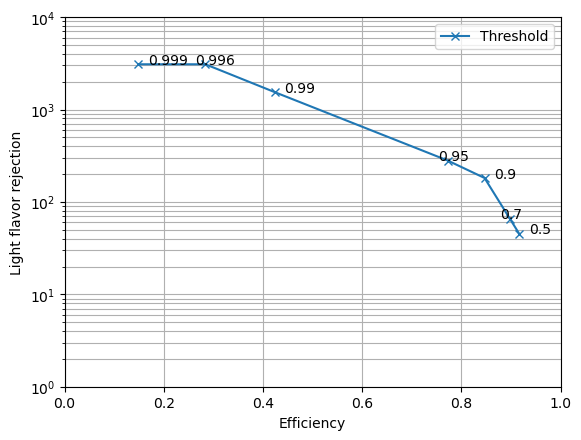

In [112]:
# plot rejection-efficiency
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(1)
plt.yscale("log")
light_rejection = []
for i_item in range(len(light_efficiency_y)):
    light_rejection.append(1.0/light_efficiency_y[i_item])
plt.plot(heavy_efficiency_x,light_rejection, label = 'Threshold',marker='x')
plt.xlabel('Efficiency')
plt.ylabel("Light flavor rejection")
#plt.title('Absorber Efficiency for Environmental Gamma-rays')
plt.xlim(0, 1)
plt.ylim(1, 1e4)
plt.grid(visible=None, which='major', axis='both')
plt.grid(visible=None, which='minor', axis='both')
for i in range(len(heavy_efficiency_x)):
    if i%2==0:
        xytext=(heavy_efficiency_x[i] + 0.02, light_rejection[i] + 0.02)
    else:
        xytext=(heavy_efficiency_x[i] - 0.02, light_rejection[i] - 0.02)
    plt.annotate(threshold_list[i], xy=(heavy_efficiency_x[i], light_rejection[i]), xytext=xytext)
plt.legend()
plt.show()

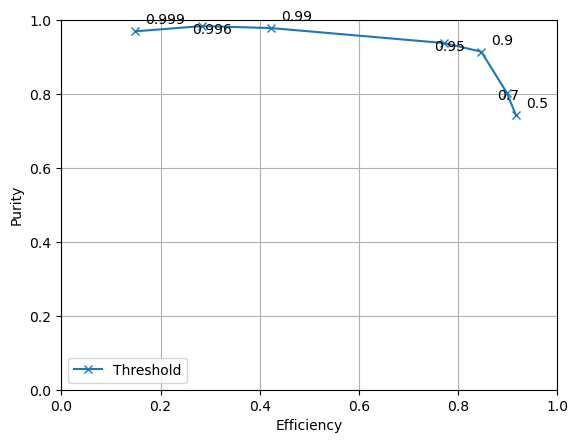

In [113]:
# plot purity-efficiency
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(1)
plt.plot(heavy_efficiency_x,purity_y, label = 'Threshold',marker='x')
plt.xlabel('Efficiency')
plt.ylabel("Purity")
#plt.title('Absorber Efficiency for Environmental Gamma-rays')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(visible=None, which='major', axis='both')
plt.grid(visible=None, which='minor', axis='both')
for i in range(len(heavy_efficiency_x)):
    if i%2==0:
        xytext=(heavy_efficiency_x[i] + 0.02, purity_y[i] + 0.02)
    else:
        xytext=(heavy_efficiency_x[i] - 0.02, purity_y[i] - 0.02)
    plt.annotate(threshold_list[i], xy=(heavy_efficiency_x[i], purity_y[i]), xytext=xytext)
plt.legend()
plt.show()

In [114]:
# plot AUC 
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
random.shuffle(jetDataset_list_training)
random.shuffle(jetDataset_list_validation)
y_true=[]
y_pred=[]
for i_item in range(len(jetDataset_list_training)):
        jetSequence,jetLabel = jetDataset_list_training[i_item]
        jetSequence = jetSequence.to(device)
        jetLabel = jetLabel.to(device)
        # forward propagation
        with torch.no_grad():
            out = jetClassification(jetSequence)
            out = F.sigmoid(out)
            y_pred.append(float(out[0][0][0]))
            y_true.append(float(jetLabel[0][0][0]))
        if i_item > 10000:
            break

In [115]:
y_true_test=[]
y_pred_test=[]
for i_item in range(len(jetDataset_list_validation)):
        jetSequence,jetLabel = jetDataset_list_validation[i_item]
        jetSequence = jetSequence.to(device)
        jetLabel = jetLabel.to(device)
        # forward propagation
        with torch.no_grad():
            out = jetClassification(jetSequence)
            out = F.sigmoid(out)
            #print(jetLabel)
            #print(out)
            if out[0][0][0]>0.8:
                out[0][0][0] = 1
            else:
                out[0][0][0] = 0
            y_pred_test.append(float(out[0][0][0]))
            y_true_test.append(float(jetLabel[0][0][0]))
        if i_item > 10000:
            break

AUC in training set: 0.9892473978158927
AUC in validation set: 0.9326756235691046


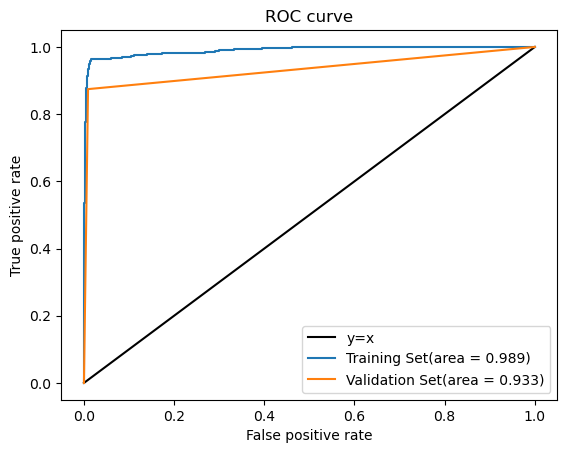

In [116]:
%matplotlib inline
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred)
print("AUC in training set:",roc_auc)

fpr_test, tpr_test, thresholds_test = metrics.roc_curve(y_true_test, y_pred_test)
roc_auc_test = roc_auc_score(y_true_test, y_pred_test)
print("AUC in validation set:",roc_auc_test)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k-', label = 'y=x')
plt.plot(fpr, tpr, label='Training Set(area = {:.3f})'.format(roc_auc))
plt.plot(fpr_test, tpr_test, label='Validation Set(area = {:.3f})'.format(roc_auc_test))
plt.xlabel('False positive rate')
plt.ylabel("True positive rate")
plt.title('ROC curve')
plt.legend()
plt.show()